In [1]:
import math
import sys
import xlrd
import numpy as np
from shapely.geometry import Point, Polygon,MultiPolygon,MultiPoint
from shapely.affinity import translate
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal, ogr,osr,gdal_array
import os
from scipy.interpolate import griddata
# from mpl_toolkits.basemap import Basemap
from numpy import linspace
from numpy import meshgrid
import folium
from folium import plugins
import geojsoncontour
import itertools
import scipy as sp
import scipy.ndimage
import branca
import statistics as stat

### '''该类为有化学反应的点源污染模型'''

In [2]:
class pointWithReaction():
    def __init__(self,q,u,k):
        self.q = q
        self.u = u
        self.k = k
#点源有化学反应的计算公式
    def model(self,x,y,sigmay,sigmaz,h):
        '''c——地面中任意一点(x,y)的污染物浓度
           h——污染源有效高度,为输入的数据
           q——单位时间污染源的排放源强，输入数据
           u——平均风速，输入数据
           sigmay——水平方向扩散参数，通过函数调用获得
           sigmaz——垂直方向扩散参数，通过函数调用获得
           K——化学转化速率常数'''
        c = self.q/(2*math.pi*sigmay*sigmaz*self.u)*math.exp(-y**2/(2*sigmay**2)-self.k*x/self.u-h**2/(2*sigmaz**2))
        return c  
    
    #Holland 矫正
    def compute1(self,us,u,Ts,Ta,D):
        """
        H:烟气抬升高度 m
        :param us: 烟气出口流速 m/s
        :param u: 烟气出口平均流速 m/s
        :param Ts: 烟气出口温度 k
        :param Ta: 环境大气平均温度 k
        :param D: 烟囱出口直径 m
        :return:
        """
        H = us / u * (1.5 + 2.7 * ((Ts - Ta)/ Ts) * D)
        return H
    
    #Briggs 矫正
    def compute2(self,vs,u,Ts,Ta,D,h,Pa,Qv):
        """
        H:计算的结果
        D：烟囱出口直径，
        h：排气筒距地面高度，
        u：烟气出口处平均流速，
        Pa：烟气出口出的大气压，
        Qv：实际点源排放效率，
        Ts：烟气出口温度，
        Ta：环境大气平均烟气出口温度温度，
        Vs：排气筒烟气排出速度，m/s
        Qh：烟气的热释放率，
        :return:
        """
        Qh =0.35 * Pa * Qv * (Ts-Ta)/ Ts
        # 对Qh的判断
        if Qh>=2100 and (Ts-Ta)>=35 :
            if Qh>=2100:
                n0 = 1.427
                n1 = 1/3
                n2 = 2/3
                H = n0 * pow(Qh,n1) * pow(h,n2) * pow(u,-1)
        else:
            n0 = 0.332
            n1 = 3/5
            n2 = 2/5
            H = n0 * pow(Qh, n1) * pow(h, n2) * pow(u, -1)
        if Qh<2100 and Qh>1700:
            H1 = 2 * (1.5 *vs * D + 0.01 * Qh ) / u-0.048 * (Qh - 1700) / u
            H2 = 0.332 * pow(Qh,3/5) * pow(h,2/5) * pow(u,-1)
            H = H1 + (H2 - H1) * (Qh - 1700) / 400

        else:
            H = 2 * (1.5 * vs * D + 0.01 * Qh) / u
        return H
    
#点源横向扩散参数计算函数
    def sigmy(self,l,p):        #l——下风距离，m；p——大气稳定度等级
        a = 0.0
        r = 0.0         #将a和γ初始值设置为0
        if p == 'A':
            if l <= 1000.0:
                a = 0.425809
                r = 0.901074
            else:
                a = 0.602052
                r = 0.850934
        if p =='B':
            if l <= 1000.0:
                a = 0.281846
                r = 0.914370
            else:
                a = 0.396353
                r = 0.865014
        if p =='B-C':
            if l <= 1000.0:
                a = 0.229500
                r = 0.919325
            else:
                a = 0.314238
                r = 0.875086
        if p =='C':
            if l <= 1000.0:
                a = 0.177154
                r = 0.924279
            else:
                a = 0.232123
                r = 0.885157
        if p =='C-D':
            if l <= 1000.0:
                a = 0.143940
                r = 0.926849
            else:
                a = 0.189396
                r = 0.886940
        if p =='D':
            if l <= 1000:
                a = 0.110726
                r = 0.929418
            else:
                a = 0.146669
                r = 0.888723
        if p =='D-E':
            if l <= 1000.0:
                a = 0.110726
                r = 0.929418
            else:
                a = 0.146669
                r = 0.888723
        if p =='E':
            if l <= 1000.0:
                a = 0.0864001
                r = 0.920818
            else:
                a = 0.101947
                r = 0.896864
        if p == 'F':
            a = 0.0553634
            r = 0.929418
        return a*l**r           #返回最终的扩散参数值
    
#点源纵向扩散参数计算函数
    def sigmz(self,l,p):     # l——下风距离，m；p——大气稳定度等级
        a = 0.0
        r = 0.0         # 将a和γ初始值设置为0
        if p == 'A':
            if l <= 300.0:
                a = 0.0799904
                r = 1.12154
            elif l > 300.0 and l <= 500.0:
                a = 0.00854771
                r = 1.51360
            else:
                a = 0.000211545
                r = 2.10881
        if p == 'B':
            if l <= 500.0:
                a = 0.127190
                r = 0.964435
            else:
                a = 0.057025
                r = 0.109356
        if p == 'B-C':
            if l <= 500.0:
                a = 0.114682
                r = 0.941015
            else:
                a = 0.0757182
                r = 1.00770
        if p == 'C':
                a = 0.106803
                r = 0.917595
        if p == 'C-D':
            if l <= 2000.0:
                a = 0.126152
                r = 0.838628
            elif l > 2000.0 and l <= 10000.0:
                a = 0.235667
                r = 0.756410
            else:
                a = 0.136659
                r = 0.815575
        if p == 'D':
            if l <= 1000.0:
                a = 0.104634
                r = 0.826212
            elif l > 1000.0 and l <= 10000.0:
                a = 0.400167
                r = 0.632023
            else:
                a = 0.810763
                r = 0.55536
        if p == 'D-E':
            if l <= 2000.0:
                a = 0.111771
                r = 0.776864
            elif l > 2000.0 and l <= 10000.0:
                a = 0.5289922
                r = 0.572347
            else:
                a = 1.03810
                r = 0.499149
        if p == 'E':
            if l <= 1000.0:
                a = 0.0927529
                r = 0.788370
            elif l > 1000.0 and l <= 10000.0:
                a = 0.433384
                r = 0.565188
            else:
                a = 1.73241
                r = 0.414743
        if p == 'F':
            if l <= 1000.0:
                a = 0.0620765
                r = 0.784400
            elif l > 1000.0 and l <= 10000.0:
                a = 0.370015
                r = 0.525969
            else:
                a = 2.40691
                r = 0.322659
        return a * l ** r           #返回最终的扩散参数值

## '''该类为无化学反应的点源污染模型'''

In [3]:
class pointNoReaction(pointWithReaction):
    def __init__(self,q,u):
        self.q = q
        self.u = u

# 点源无化学反应的计算公式
    def model(self,y,sigmay,sigmaz,h):
        '''c——地面中任意一点(x,y)的污染物浓度
           h——污染源有效高度,为输入的数据
           q——单位时间污染源的排放源强，输入数据
           u——平均风速，输入数据
           sigmay——水平方向扩散参数，通过函数调用获得
           sigmaz——垂直方向扩散参数，通过函数调用获得'''
        c = self.q/(math.pi*sigmay*sigmaz*self.u)*math.exp(-y**2/(2*sigmay**2))*math.exp(-h**2/(2*sigmaz**2))
        return c

## '''该类为有化学反应的面源污染模型'''

In [4]:
class nonPointReaction():
    def __init__(self,q,u,k):
        self.q = q
        self.u = u
        self.k = k
#面源有化学反应的计算公式
    def model(self,x,y,sigmay1,sigmaz1,h):
        '''c——地面中任意一点(x,y)的污染物浓度
           h——污染源有效高度,为输入的数据
           q——单位时间污染源的排放源强，输入数据
           u——平均风速，输入数据
           sigmay1——修复后的水平方向扩散参数，通过函数调用获得
           sigmaz1——修复后的垂直方向扩散参数，通过函数调用获得
           K——化学转化速率常数'''
        c = self.q/(4*math.pi*sigmay1*sigmaz1*self.u)*math.exp(-0.5*(y**2/sigmay1**2+h**2/sigmaz1**2)-self.k*x/self.u)
        return c 

#点源后退距离    
    def back(self,wind_angle):
        d = 0
        if wind_angle == 0 or wind_angle == 90 or wind_angle == 180 or wind_angle == 270:
            theta1 =0
        elif wind_angle == 45 or wind_angle == 135 or wind_angle == 225 or wind_angle == 315:
            theta1 = math.pi/4
        else :
            theta1 = math.pi/8
        d = A/(4 * math.cos(theta1))
        return d
        
    # 面源横向扩散参数计算函数
    def sigmy1(self,l,p,A):  # l——下风距离，m；p——大气稳定度等级
        a = 0.0
        r = 0.0
        if p == 'A':
            if l <= 1000.0:
                a = 0.425809
                r = 0.901074
            else:
                a = 0.602052
                r = 0.850934
        if p == 'B':
            if l <= 1000.0:
                a = 0.281846
                r = 0.914370
            else:
                a = 0.396353
                r = 0.865014
        if p == 'B-C':
            if l <= 1000.0:
                a = 0.229500
                r = 0.919325
            else:
                a = 0.314238
                r = 0.875086
        if p == 'C':
            if l <= 1000.0:
                a = 0.177154
                r = 0.924279
            else:
                a = 0.232123
                r = 0.885157
        if p == 'C-D':
            if l <= 1000.0:
                a = 0.143940
                r = 0.926849
            else:
                a = 0.189396
                r = 0.886940
        if p == 'D':
            if l <= 1000.0:
                a = 0.110726
                r = 0.929418
            else:
                a = 0.146669
                r = 0.888723
        if p == 'D-E':
            if l <= 1000.0:
                a = 0.110726
                r = 0.929418
            else:
                a = 0.146669
                r = 0.888723
        if p == 'E':
            if l <= 1000.0:
                a = 0.0864001
                r = 0.920818
            else:
                a = 0.101947
                r = 0.896864
        if p == 'F':
            a = 0.0553634
            r = 0.929418
        x0 = 0.0
        x0 = float(A / (8.6 * a)) ** (1 / r)
        return a * (l + x0) ** r
    
    #面源纵向扩散参数计算函数
    def sigmz1(self,l, p):  # l——下风距离，m；p——大气稳定度等级
        a = 0.0
        r = 0.0  # 将a和γ初始值设置为0
        if p == 'A':
            if l <= 300.0:
                a = 0.0799904
                r = 1.12154
            elif l > 300.0 and l <= 500.0:
                a = 0.00854771
                r = 1.51360
            else:
                a = 0.000211545
                r = 2.10881
        if p == 'B':
            if l <= 500.0:
                a = 0.127190
                r = 0.964435
            else:
                a = 0.057025
                r = 0.109356
        if p == 'B-C':
            if l <= 500.0:
                a = 0.114682
                r = 0.941015
            else:
                a = 0.0757182
                r = 1.00770
        if p == 'C':
            a = 0.106803
            r = 0.917595
        if p == 'C-D':
            if l <= 2000.0:
                a = 0.126152
                r = 0.838628
            elif l > 2000.0 and l <= 10000.0:
                a = 0.235667
                r = 0.756410
            else:
                a = 0.136659
                r = 0.815575
        if p == 'D':
            if l <= 1000.0:
                a = 0.104634
                r = 0.826212
            elif l > 1000.0 and l <= 10000.0:
                a = 0.400167
                r = 0.632023
            else:
                a = 0.810763
                r = 0.55536
        if p == 'D-E':
            if l <= 2000.0:
                a = 0.111771
                r = 0.776864
            elif l > 2000.0 and l <= 10000.0:
                a = 0.5289922
                r = 0.572347
            else:
                a = 1.03810
                r = 0.499149
        if p == 'E':
            if l <= 1000.0:
                a = 0.0927529
                r = 0.788370
            elif l > 1000.0 and l <= 10000.0:
                a = 0.433384
                r = 0.565188
            else:
                a = 1.73241
                r = 0.414743
        if p == 'F':
            if l <= 1000.0:
                a = 0.0620765
                r = 0.784400
            elif l > 1000.0 and l <= 10000.0:
                a = 0.370015
                r = 0.525969
            else:
                a = 2.40691
                r = 0.322659
        x0 = 0.0
        x0 = (float(h / (2.5 * a))) ** (1 / r)
        return a * (l + x0) ** r  # 返回最终的扩散参数值

## '''该类为无化学反应的面源污染模型'''

In [5]:
class nonPointNo(nonPointReaction):
    def __init__(self,q,u):
        self.q = q
        self.u = u
#面源无化学反应的计算公式
    def model(self,y,sigmay1,sigmaz1,h):
        '''c——地面中任意一点(x,y)的污染物浓度
           h——污染源有效高度,为输入的数据
           q——单位时间污染源的排放源强，输入数据
           u——平均风速，输入数据
           sigmay1——修复后的水平方向扩散参数，通过函数调用获得
           sigmaz1——修复后的垂直方向扩散参数，通过函数调用获得'''
        c = self.q/(4*math.pi*sigmay1*sigmaz1*self.u)*math.exp(-0.5*(y**2/sigmay1**2+h**2/sigmaz1**2))
        return c

In [6]:
# 需要導入模塊: import gdal [as 別名]
# 或者: from gdal import RasterizeLayer [as 別名]
# 将面转栅格
def ploy2raster(shapefile,RASTER_PATH,cellSize,field_name=False):
    # from osgeo import gdal, ogr

    # Define pixel_size and NoData value of new raster
    pixel_size = cellSize
    NoData_value = -9999
    
    # Filename of input OGR file
    vector_ptsShp_fn = shapefile
    
    # Filename of the raster Tiff that will be created
    raster_ptsShp_fn = RASTER_PATH
    
    # Open the data source and read in the extent
    source_ds = ogr.Open(vector_ptsShp_fn)
    source_layer = source_ds.GetLayer()
    proj = source_layer.GetSpatialRef()
    x_min, x_max, y_min, y_max = source_layer.GetExtent()
    
    # Create the destination data source
    x_res = int((x_max - x_min) / pixel_size)
    y_res = int((y_max - y_min) / pixel_size)

    # Output
    out_driver = gdal.GetDriverByName('GTiff')
    if os.path.exists(raster_ptsShp_fn):
        out_driver.Delete(raster_ptsShp_fn)

    target_ds = out_driver.Create(raster_ptsShp_fn, x_res, y_res, 1, gdal.GDT_Float32 )
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    target_ds.SetProjection(proj.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)
    
    # Rasterize
    # gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[0])
    # Rasterize
    if field_name:
        gdal.RasterizeLayer(target_ds,[1], source_layer,options=["ATTRIBUTE={0}".format(field_name),"ALL_TOUCHED=TRUE"])
        # print("write:",field_name)
    else:
        gdal.RasterizeLayer(target_ds,[1], source_layer,burn_values=[-1])   
    band.FlushCache()
    band=None
    target_ds = None 
    source_layer = None
    
    return gdal.Open(RASTER_PATH).ReadAsArray()


In [7]:
# 坐标转换
def change_crs(series, in_crs, to_crs):
    '''
    Change the projection of a series of coordinates
    :param series:
    :param to_crs:
    :param in_crs:
    :return: series of reprojected coordinates
    >>> import swmmio
    >>> m = swmmio.Model(MODEL_FULL_FEATURES_XY)
    >>> proj4_str = '+proj=tmerc +lat_0=36.16666666666666 +lon_0=-94.5 +k=0.9999411764705882 +x_0=850000 +y_0=0 +datum=NAD83 +units=us-ft +no_defs' #"+init=EPSG:102698"
    >>> m.crs = proj4_str
    >>> nodes = m.nodes()
    >>> change_crs(nodes['coords'], proj4_str, "EPSG:4326")
    Name
    J3    [(39.236286854940964, -94.64346373821752)]
    1      [(39.23851590020802, -94.64756446847099)]
    2       [(39.2382157223383, -94.64468629488778)]
    3      [(39.23878251491925, -94.64640342340165)]
    4     [(39.238353081411915, -94.64603818939938)]
    5      [(39.23797714290924, -94.64589184224722)]
    J2     [(39.23702605103406, -94.64543916929885)]
    J4     [(39.23633648359375, -94.64190240294558)]
    J1     [(39.23723558954326, -94.64583338271147)]
    Name: coords, dtype: object
    '''
    try:
        import pyproj
        from pyproj import Transformer
    except ImportError:
        raise ImportError('pyproj module needed. get this package here: ',
                          'https://pypi.python.org/pypi/pyproj')

    # SET UP THE TO AND FROM COORDINATE PROJECTION
    transformer = Transformer.from_crs(in_crs, to_crs, always_xy=True)

    # convert coords in coordinates, vertices, and polygons inp sections
    # transform to the typical 'WGS84' coord system
    def get_xys(xy_row):
        # need to reverse to lat/long after conversion
        return [transformer.transform(x, y) for x, y in xy_row]

    if isinstance(series, pd.Series):

        # unpack the nested coords
        xs = [xy[0][0] for xy in series.to_list()]
        ys = [xy[0][1] for xy in series.to_list()]

        # transform the whole series at once
        xs_trans, ys_trans = transformer.transform(xs, ys)

        # increase nest level and return pd.Series
        return pd.Series(index=series.index, data=[[coords] for coords in zip(xs_trans, ys_trans)])

    if isinstance(series, pd.DataFrame):
        # zipped_coords = list(zip(series.X, series.Y))
        xs_trans, ys_trans = transformer.transform(series.X, series.Y)
        df = pd.DataFrame(data=zip(xs_trans, ys_trans), columns=["X", "Y"], index=series.index)
        return df
    elif isinstance(series, (list, tuple)):
        if isinstance(series[0], (list, tuple)):
            # unpack the nested coords
            xs = [x for x, y in series]
            ys = [y for x, y in series]
            # add and modified by jip
            xs_trans, ys_trans = transformer.transform(xs, ys)
            return [[lat,lng] for lat, lng in zip(xs_trans,ys_trans)]
            # return list(zip(transformer.transform(xs, ys)))
        elif isinstance(series[0], (dict)): 
            xs = [x for x, y in series]
            ys = [y for x, y in series]
            xs_trans, ys_trans = transformer.transform(xs, ys)
            return [[x,y] for x, y in zip(xs_trans,ys_trans)]
        else:
            return transformer.transform(*series)


In [8]:
# 创建扇形图形，返回面对象，正北为0
def sector(center, start_angle, end_angle, radius, steps=200):
    def polar_point(origin_point, angle,  distance):
        return [origin_point.x + math.sin(math.radians(angle)) * distance, origin_point.y + math.cos(math.radians(angle)) * distance]

    if start_angle > end_angle:
        start_angle = start_angle - 360
    else:
        pass
    step_angle_width = (end_angle-start_angle) / steps
    sector_width = (end_angle-start_angle) 
    segment_vertices = []

    segment_vertices.append(polar_point(center, 0,0))
    segment_vertices.append(polar_point(center, start_angle,radius))

    for z in range(1, steps):
        segment_vertices.append((polar_point(center, start_angle + z * step_angle_width,radius)))
    segment_vertices.append(polar_point(center, start_angle+sector_width,radius))
    segment_vertices.append(polar_point(center, 0,0))
    return Polygon(segment_vertices)


### 网格剖分，大地投影坐标系，正东方向x轴

In [9]:
def create_model_grid(deltx,delty,delt_angle,wind_angle,radius):
    '''
    deltx=50 # x方向空间步长，m, 该变量由界面端传过来
    delty=50 # y方向空间步长，m, 该变量由界面端传过来
    # x=1000 # x方向计算长度，m，以排放口向扩散方向, 该变量由界面端传过来
    # y=500 # y方向计算长度，m，以排放口向左右扩散方向, 该变量由界面端传过来
    radius = 1000 # 沿风向计算长度，m，该变量由界面端传过来
    wind_angle = 0 # 0度为正北风，顺时针转
    delt_angle = 30 # 以风向左右30度范围作为计算范围，度，该变量由界面端传过来
    '''
    # 创建扇形
    # 风向换算角度
    left_angle = wind_angle - delt_angle
    right_angle = wind_angle + delt_angle
    print(left_angle)
    print(right_angle)  
    fan_shape = sector(Point(0,0),left_angle,right_angle,radius) 

    # 测试时，打印扇形，预览一下    
    plt.plot(*fan_shape.exterior.xy)
    ax = plt.gca()
    ax.set_aspect('equal')

    # 根据扇形的边界极限得到网格的四至点
    extent = fan_shape.bounds
    print(extent)
    left = extent[0]
    down = extent[1]
    right = extent[2]
    up = extent[3]

    # 计算行列数
    rows = math.ceil((up - down) / delty )
    cols = math.ceil((right - left) / deltx)   
    print(rows)
    print(cols)
    #遍历列，每一列写入格网
    col = 0
    #中心点坐标存入location数组中
    location = []
    #grid
    mesh = []
    cal_mesh = []
    #左上角第一个格子的四个顶点范围
    x_left = left
    x_right = x_left + deltx
    y_top = up
    y_bottom = y_top - delty

    while col<cols:
        #初始化，每一列写入完成都把上下范围初始化
        ring_Ytop = y_top
        ring_Ybottom = y_bottom
        #遍历行，对这一列每一行格子创建和写入
        row = 0
        while row<rows:
            #创建左上角第一个格子
            grd = Polygon(((x_left,ring_Ytop),(x_right,ring_Ytop),(x_right,ring_Ybottom),(x_left,ring_Ybottom)))
            
            #判断该网格是否与扇形相交,若相交则求出中心点坐标并存入数组location中
            if fan_shape.intersects(grd) == True:
                center_x = x_left + deltx/2
                center_y = ring_Ybottom + delty/2
                location.append((center_x,center_y))
                cal_mesh.append(grd)
            #写入几何多边形
            mesh.append(grd)
            # 下一多边形，更新上下范围
            row += 1
            ring_Ytop = ring_Ytop - delty
            ring_Ybottom = ring_Ybottom - delty
        # 一列写入完成后，下一列，更新左右范围
        col = col + 1
        x_left = x_left + deltx
        x_right = x_right + deltx     

    return location,mesh,cal_mesh


### 将正东方向x轴偏移到风向x轴

In [10]:
## 正东向风向坐标偏移
def windcoords_transfer(wind_angle,xy):
#wind_angle = 0 # 0度为正北风，顺时针转
    theta = math.pi*((wind_angle-90)/180)        #将度转换为弧度
    #新建数组存储转换后的坐标
    coordinate = []
    #将坐标转换成风向为x的坐标系的点
    for i in range(len(xy)):
        x1 = xy[i][0]           #需要进行模拟点p的x坐标位置
        y1 = xy[i][1]           #需要进行模拟点p的y坐标位置
    #坐标转换
        x2 = x1 * math.cos(theta) + y1 * math.sin(theta)      #x2为新坐标中p点的x坐标
        y2 = y1 * math.cos(theta) - x1 * math.sin(theta)      #y2为新坐标中p点的y坐标
        coordinate.append((x2,y2))         #将转化后的坐标值储存进coordinate列表
    #print("co=",coordinate)
    return coordinate

In [11]:
def cal_air_diffusion(number=1,h_fix_method='Holland',mesh_pts=[],q=1000,u=10,h=10,k=0.0052194,\
    w='D',us=1,vs=1,Ts=100,Ta=100,D=4,Pa=10.057,Qv=10,wind_angle=90,A=100):
    con = []
    # gauss_model = {1:pointWithReaction,         
    #                2:pointNoReaction,
    #                3:nonPointReaction,
    #                4:nonPointNo}
    if number == 1:
        for pt in mesh_pts:
            sigma_y = pointWithReaction(q,u,k).sigmy(math.sqrt(pt.x*pt.x+pt.y*pt.y),w)
            sigma_z = pointWithReaction(q,u,k).sigmz(math.sqrt(pt.x*pt.x+pt.y*pt.y),w)
            if h_fix_method == 'Holland':
                high = h+pointWithReaction(q,u,k).compute1(us,u,Ts,Ta,D)
            else:
                high = h+pointWithReaction(q,u,k).compute2(vs,u,Ts,Ta,D,h,Pa,Qv)
            con.append(pointWithReaction(q,u,k).model(pt.x,pt.y, sigma_y, sigma_z,h))
        #print(con)
    elif number ==2:
        for pt in mesh_pts:
            sigma_y = pointNoReaction(q,u).sigmy(math.sqrt(pt.x*pt.x+pt.y*pt.y),w)
            sigma_z = pointNoReaction(q,u).sigmz(math.sqrt(pt.x*pt.x+pt.y*pt.y),w)
            if h_fix_method == 'Holland':
                high = h+pointNoReaction(q,u).compute1(us,u,Ts,Ta,D)
            else:
                high = h+pointNoReaction(q,u).compute2(vs,u,Ts,Ta,D,h,Pa,Qv)
            con.append(pointNoReaction(q,u).model(pt.y, sigma_y, sigma_z,h))
        #print(con)
    elif number ==3:
        for pt in mesh_pts:
            d = nonPointReaction(q,u,k).back(wind_angle)
            x_new = pt.x+d
            sigma_y = nonPointReaction(q,u,k).sigmy1(math.sqrt(x_new*x_new+pt.y*pt.y),w,A)
            sigma_z = nonPointReaction(q,u,k).sigmz1(math.sqrt(x_new*x_new+pt.y*pt.y),w)
            con.append(nonPointReaction(q,u,k).model(x_new,pt.y,sigma_y, sigma_z,h))
        #print(con)
    else :
        for pt in mesh_pts:
            d = nonPointReaction(q,u,k).back(wind_angle)
            x_new = pt.x+d
            sigma_y = nonPointNo(q,u).sigmy1(math.sqrt(x_new*x_new+pt.y*pt.y),w,A)
            sigma_z = nonPointNo(q,u).sigmz1(math.sqrt(x_new*x_new+pt.y*pt.y),w)
            con.append(nonPointNo(q,u).model(pt.y, sigma_y, sigma_z,h))
    return con


In [12]:
def ix2xy(r,c,gt):
    '''Gets x,y from row and column'''
    x = gt[0] + r * gt[1]
    y = gt[3] + c * gt[5]
    return(x,y)

### 输入参数

In [13]:
deltx=100 # m，x方向计算步长
delty=100 # m，y方向计算步长
delt_angle=22.5 # 度，计算范围为风向左右两侧多少多少度的扇形区域
wind_angle=90 # 度，风向，正北为0，顺时针
radius=3500 # m，计算范围，扇形半径

x0=107.6314 # 排放口经度
y0=37.73866 # 排污口纬度

crs_in = 'EPSG:4326'
crs_out = 'EPSG:4526'

q=7342
w='D'
u=2.5
k=0.0052194

h_fix_method='Holland'

us=3.42
u=2.5
Ts=393
Ta=290
D=4
A = 100     #面源单元边长
num=1       #模式选择 1-点源化学反应：2-点源无反应模型：3-面源化学反应模型；4-面源无反应模型

vs=15
h=80
Pa=10.057
Qv=141.95

### 网格剖分

67.5
112.5
(0.0, -1339.392013277814, 3500.0, 1339.3920132778144)
27
35


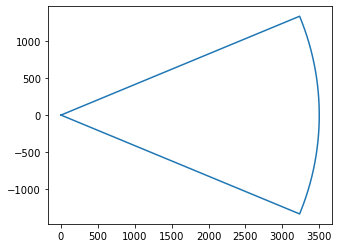

In [14]:
xy,grd,cal_grd = create_model_grid(deltx,delty,delt_angle,wind_angle,radius)

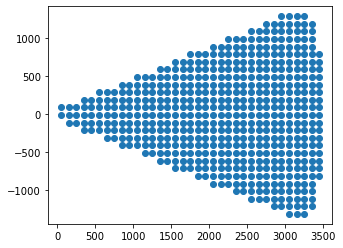

In [15]:
mesh_pts = [Point(coord[0], coord[1]) for coord in xy]
xs = [point.x for point in mesh_pts]
ys = [point.y for point in mesh_pts]
plt.scatter(xs, ys)
ax = plt.gca()
ax.set_aspect('equal')

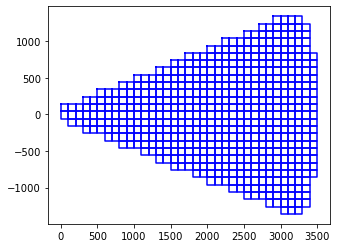

In [16]:
fig, ax = plt.subplots()
polygons = MultiPolygon(cal_grd)
for poly in polygons.geoms:
    xe, ye = poly.exterior.xy
    ax.plot(xe, ye, color="blue")
    ax.set_aspect('equal')
plt.show()

### 偏移到风向x轴

In [17]:
xy = windcoords_transfer(wind_angle,xy)

### 打印预览

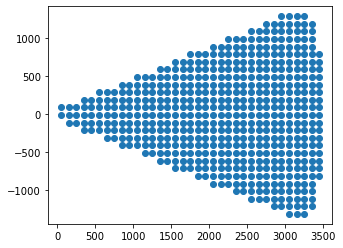

In [18]:
mesh_pts_cal = [Point(coord[0], coord[1]) for coord in xy]
xs = [point.x for point in mesh_pts_cal]
ys = [point.y for point in mesh_pts_cal]
plt.scatter(xs, ys)
ax = plt.gca()
ax.set_aspect('equal')

### 遍历坐标，根据用户输入不同的数字来启动不同的高斯模型

In [19]:
con = cal_air_diffusion(num,h_fix_method=h_fix_method,mesh_pts=mesh_pts,\
    q=q,u=u,h=h,k=k,w=w,us=us,vs=vs,Ts=Ts,Ta=Ta,D=D,Pa=Pa,Qv=Qv,wind_angle=wind_angle,\
        A=A,)
# print(con)

### 再将坐标移动到排放口投影坐标处

In [20]:
pt0 = change_crs([(x0,y0)],crs_in,crs_out)
x0_prj = pt0[0][0]
y0_prj = pt0[0][1]
mesh_pts = translate(MultiPoint(mesh_pts),x0_prj,y0_prj)


C:\Users\jip\AppData\Local\Temp\ipykernel_45396\4236418338.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xs = [point.x for point in mesh_pts]
C:\Users\jip\AppData\Local\Temp\ipykernel_45396\4236418338.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  ys = [point.y for point in mesh_pts]


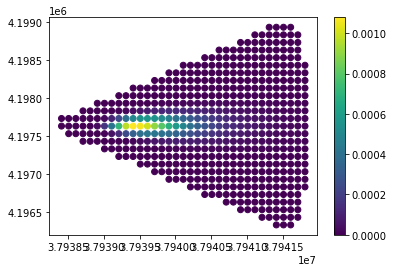

In [21]:
xs = [point.x for point in mesh_pts]
ys = [point.y for point in mesh_pts]
cs = [v for v in con ]
plt.subplots()
plt.scatter(xs, ys, c=cs,vmin=min(con), vmax=max(con))
# produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(),loc='center left', bbox_to_anchor=(1, 0.5),
#                     title="concertration")
# ax.add_artist(legend1)
# plt.set_aspect('equal')
plt.colorbar()

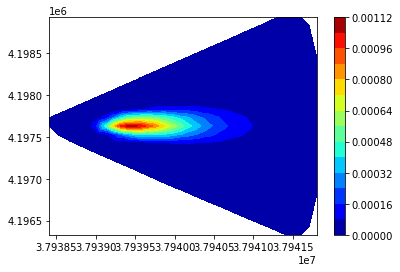

In [22]:
xi = np.linspace(min(xs), max(xs), 1000)
yi = np.linspace(min(ys), max(ys), 500)
zi = griddata((xs, ys), cs, (xi[None,:], yi[:,None]), method='linear')
# plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
plt.contourf(xi, yi, zi,15,cmap=plt.cm.jet)
plt.colorbar() 

### 计算网格偏移到排放口

In [23]:
cal_grd = translate(MultiPolygon(cal_grd),x0_prj,y0_prj)
    

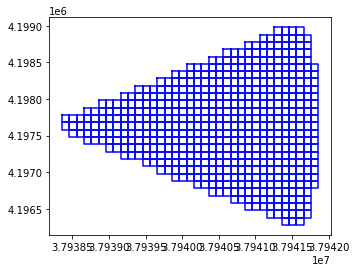

In [24]:
fig, ax = plt.subplots()
polygons = MultiPolygon(cal_grd)
for poly in polygons.geoms:
    xe, ye = poly.exterior.xy
    ax.plot(xe, ye, color="blue")
    ax.set_aspect('equal')
plt.show()

### 转成栅格tiff

In [25]:
#创建输出文件
outdriver = ogr.GetDriverByName('ESRI Shapefile')
if os.path.exists("con.shp"):
    outdriver.DeleteDataSource("con.shp")
outds = outdriver.CreateDataSource("con.shp")
# create the spatial reference system, WGS84
srs =  osr.SpatialReference()
srs.ImportFromEPSG(int(crs_out[5:]))
outlayer = outds.CreateLayer("con", srs, geom_type = ogr.wkbMultiPolygon)
# Add an ID field
conField = ogr.FieldDefn("con", ogr.OFTReal)
outlayer.CreateField(conField)

for idx, poly in enumerate(cal_grd):
    # create the WKT for the feature using Python string formatting
    # wkt = "POINT(%f %f)" %  (float(pt.x) , float(pt.y))
    # Create the point from the Well Known Txt
    geo = ogr.CreateGeometryFromWkb(poly.wkb)
    # Create the feature and set values
    featureDefn = outlayer.GetLayerDefn()
    feature = ogr.Feature(featureDefn)
    feature.SetGeometry(geo)
    feature.SetField("con", float(str(con[idx])))
    outlayer.CreateFeature(feature)
    feature = None
# Save and close the data source
outds = None

C:\Users\jip\AppData\Local\Temp\ipykernel_45396\2334488786.py:14: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for idx, poly in enumerate(cal_grd):


In [26]:
tiff_data = ploy2raster('con.shp','con.tiff',0.5,'con')

## tiff转换为等高线

In [27]:
# 将tiff转为经纬度
tif_ds = gdal.Open('con.tiff')
tiff_data = tif_ds.GetRasterBand(1).ReadAsArray()
tif_ds_n = gdal.Warp('con_ll.tiff',tif_ds,dstSRS=crs_in)
tiff_data =tif_ds_n.GetRasterBand(1).ReadAsArray()
# corner
ulx, xres, xskew, uly, yskew, yres  = tif_ds_n.GetGeoTransform()
lrx = ulx + (tif_ds_n.RasterXSize * xres)
lry = uly + (tif_ds_n.RasterYSize * yres)

print(str(ulx)+' '+str(uly)+'\n'+str(lrx)+' '+str(lry))

# Setup
temp_mean =stat.mean(cs)
temp_std  = stat.stdev(cs)
debug     = False

# Setup colormap
colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
vmin   = temp_mean - 2 * temp_std
vmax   = temp_mean + 2 * temp_std
levels = len(colors)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)

gt = tif_ds_n.GetGeoTransform()
df = pd.DataFrame.from_records(itertools.product(range(tif_ds_n.RasterYSize),range(tif_ds_n.RasterXSize)),columns=['Row','Column'])
# 非常慢，研究如何优化
df['X'], df['Y'],df['Z'] = zip(*df.apply(lambda x: ix2xy(x['Column'],x['Row'],gt),axis=1))
tif_ds_n = None

# The original data
x_orig = np.asarray(df['X'].tolist())
y_orig = np.asarray(df['Y'].tolist())
z_orig = np.asarray(df['Z'].tolist())

# Make a grid
x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 500)
y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 500)
x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)

# Grid the values
z_mesh = griddata((x_orig, y_orig), z_orig, (x_mesh, y_mesh), method='linear')
 
# Gaussian filter the grid to make it smoother
sigma = [5, 5]
z_mesh = sp.ndimage.filters.gaussian_filter(z_mesh, sigma, mode='constant')
 
# Create the contour
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors, linestyles='None', vmin=vmin, vmax=vmax)
 
# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)
 
# Set up the folium plot
geomap = folium.Map([df['Y'].mean(), df['X'].mean()], zoom_start=10, tiles="cartodbpositron")
 
# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    }).add_to(geomap)
 
# Add the colormap to the folium map
cm.caption = 'Temperature'
geomap.add_child(cm)
 
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
 
# Plot the data
geomap.save(f'data/folium_contour_temperature_map.html')

107.63036800913214 37.75278813629748
107.67190374002753 37.72647525875369


KeyboardInterrupt: 